In [1]:
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
import numpy as np
import scipy
import scipy.integrate

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
from pydmd import DMD

In this tutorial, importance of regularization when dealing with ill-conditioned data is highlited.
The data used here is the simulation results (the velocity field) for the wake behind a circular cylinder at Reynolds number Re = 100, available at the "_Data-driven science and engineering_" [website](https://www.databookuw.com/).

The computational domain comprises four grids that are nested so that the finest grid covers a domain of 9×4 and the largest grid covers a domain of 72×32, where lengths are nondimensionalized by the cylinder diameter; each grid contains 450 × 200 points, so that there are 50 points per cylinder diameter. We use a time step of $\Delta t = 0.02$, we collect $m = 150$ snapshots at regular intervals $10 \Delta t$, sampling five periods of vortex shedding.

In [11]:
nx = 449
ny = 199
dt = 0.2
xx, yy = np.meshgrid(np.linspace(-1, 8, nx), np.linspace(-2, 2, ny))


def cylinder_clean_data(X, fill=0):
    uu = X.reshape((ny, nx, -1), order="F")
    uu[(xx**2 + yy**2) < 0.5**2, :] = fill

    return uu.reshape((ny * nx, -1), order="F")


def reshaping(X):
    return X.reshape((ny, nx), order="F")


cylinder_idx = (xx**2 + yy**2) < 0.5**2

We load the data and assign it to the X matrix

In [3]:
X = np.concatenate(
    (np.load("../data/mat_UALL_1.npy"), np.load("../data/mat_UALL_2.npy"))
)

We perform the DMD decomposition, without performing a svd truncation : ```svd_rank = -1```.
As expected, the bad conditioning warning shows up.

No regularization is used in this case : ```tikhonov_regularization = None``` ( See the next part)

In [4]:
dmd = DMD(
    svd_rank=-1, exact=True, sorted_eigs=False, tikhonov_regularization=None
)
dmd.fit(X);

We then show the DMD modes, and we can see instable/noisy modes 

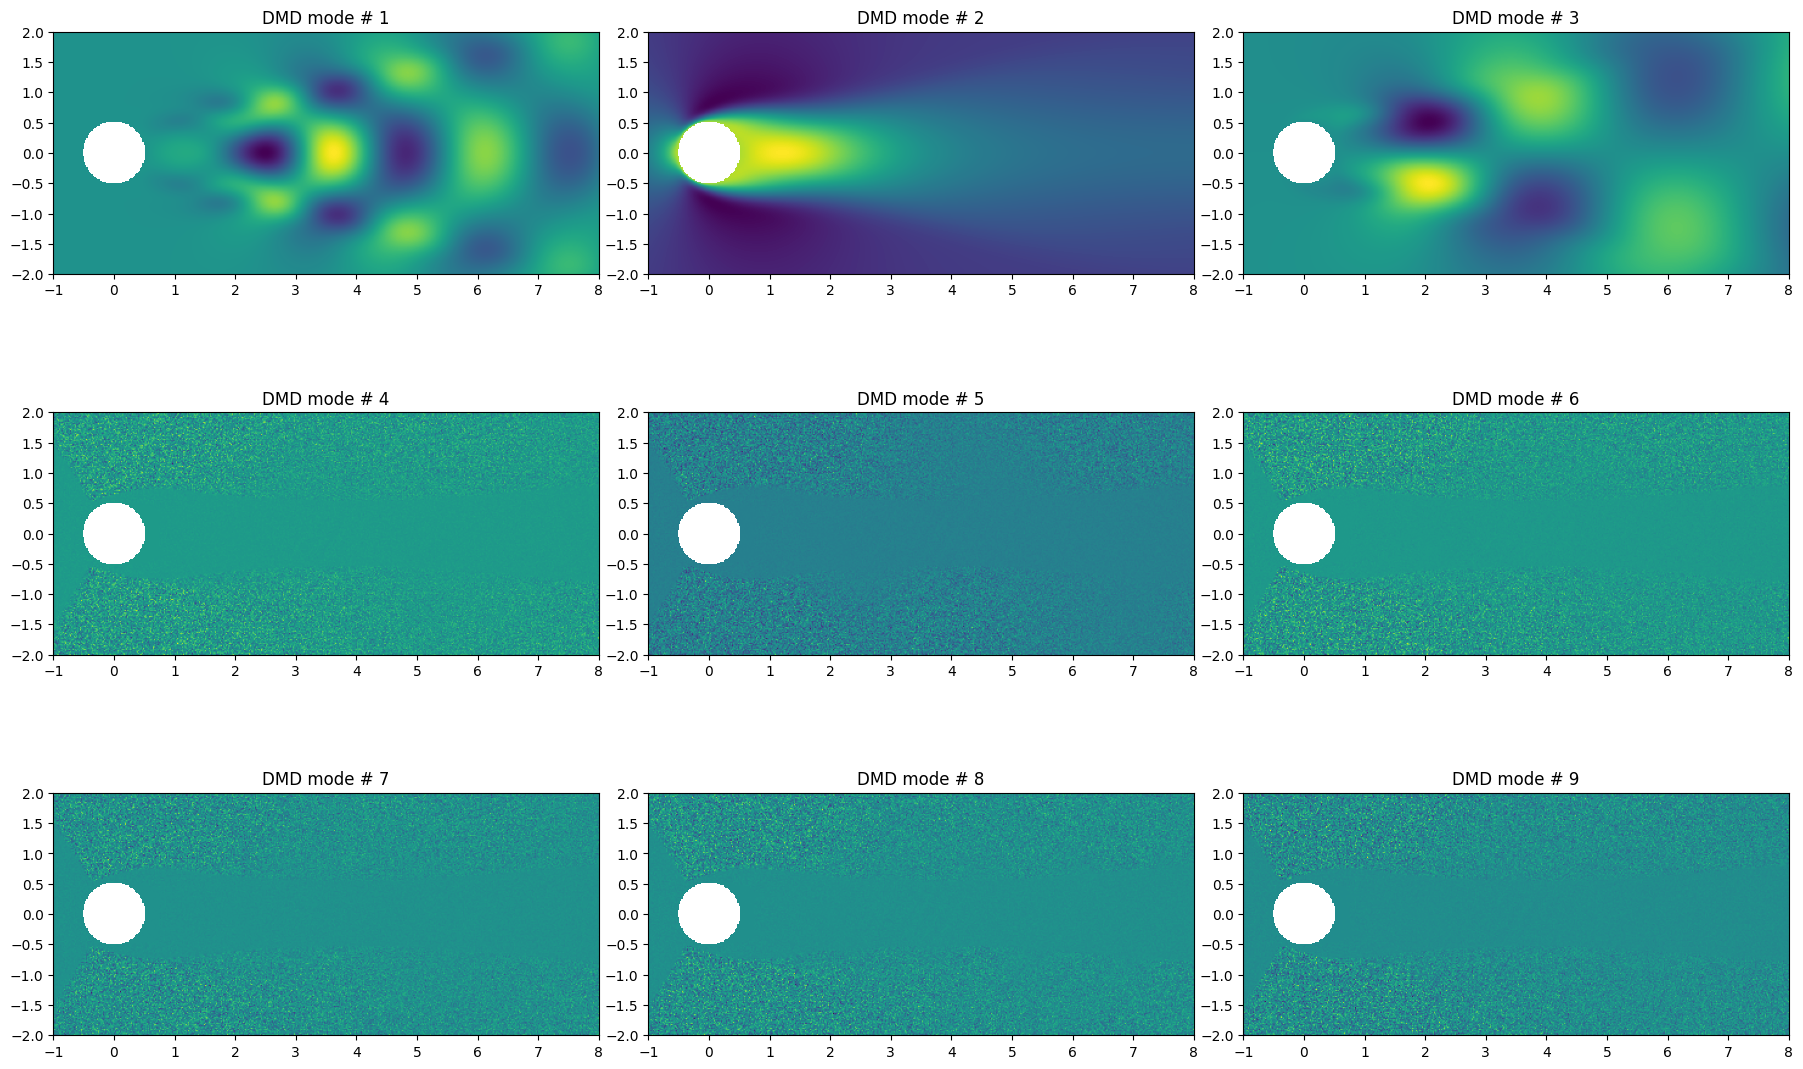

In [5]:
n_mode = np.arange(0, 18, 2)

fig, ax = plt.subplots(3, 3, figsize=(18, 12))

for i in range(3):
    for j in range(3):
        to_plot = np.real(reshaping(dmd.modes[:, n_mode[((i) * 3) + j]].copy()))
        to_plot[cylinder_idx] = np.nan
        im = ax[i, j].imshow(to_plot, extent=[-1, 8, -2, 2])
        ax[i, j].set_title(
            "DMD mode # {:d}".format(int((n_mode[((i) * 3) + j] + 2) / 2))
        )


fig.tight_layout();

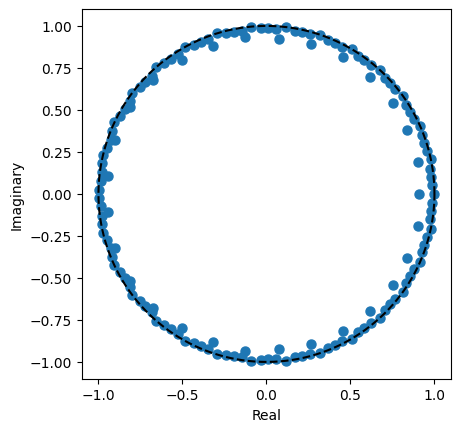

In [6]:
plt.plot(np.real(dmd.eigs), np.imag(dmd.eigs), ".", markersize=13)

theta = np.linspace(0, 2 * np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--")

plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.axis("square");

**Tikhonov Regularization**

When dealing with ill-conditioned input matrices regularization methods should be used to deal with the least square problem; we are using the well-known Tikhonov regularization in our case, i.e minimizing 
$$ \|\pmb A \pmb X - \pmb Y\|^2 + \lambda \|\pmb A\|^2$$
instead of 
$$ \|\pmb A \pmb X - \pmb Y\|^2$$

Here we use ```tikhonov_regularization = 1e-8``` instead of the default ```tikhonov_regularization = 0``` (no regularization)

In [7]:
dmd = DMD(
    svd_rank=-1, exact=True, sorted_eigs=False, tikhonov_regularization=1e-8
)
dmd.fit(X);

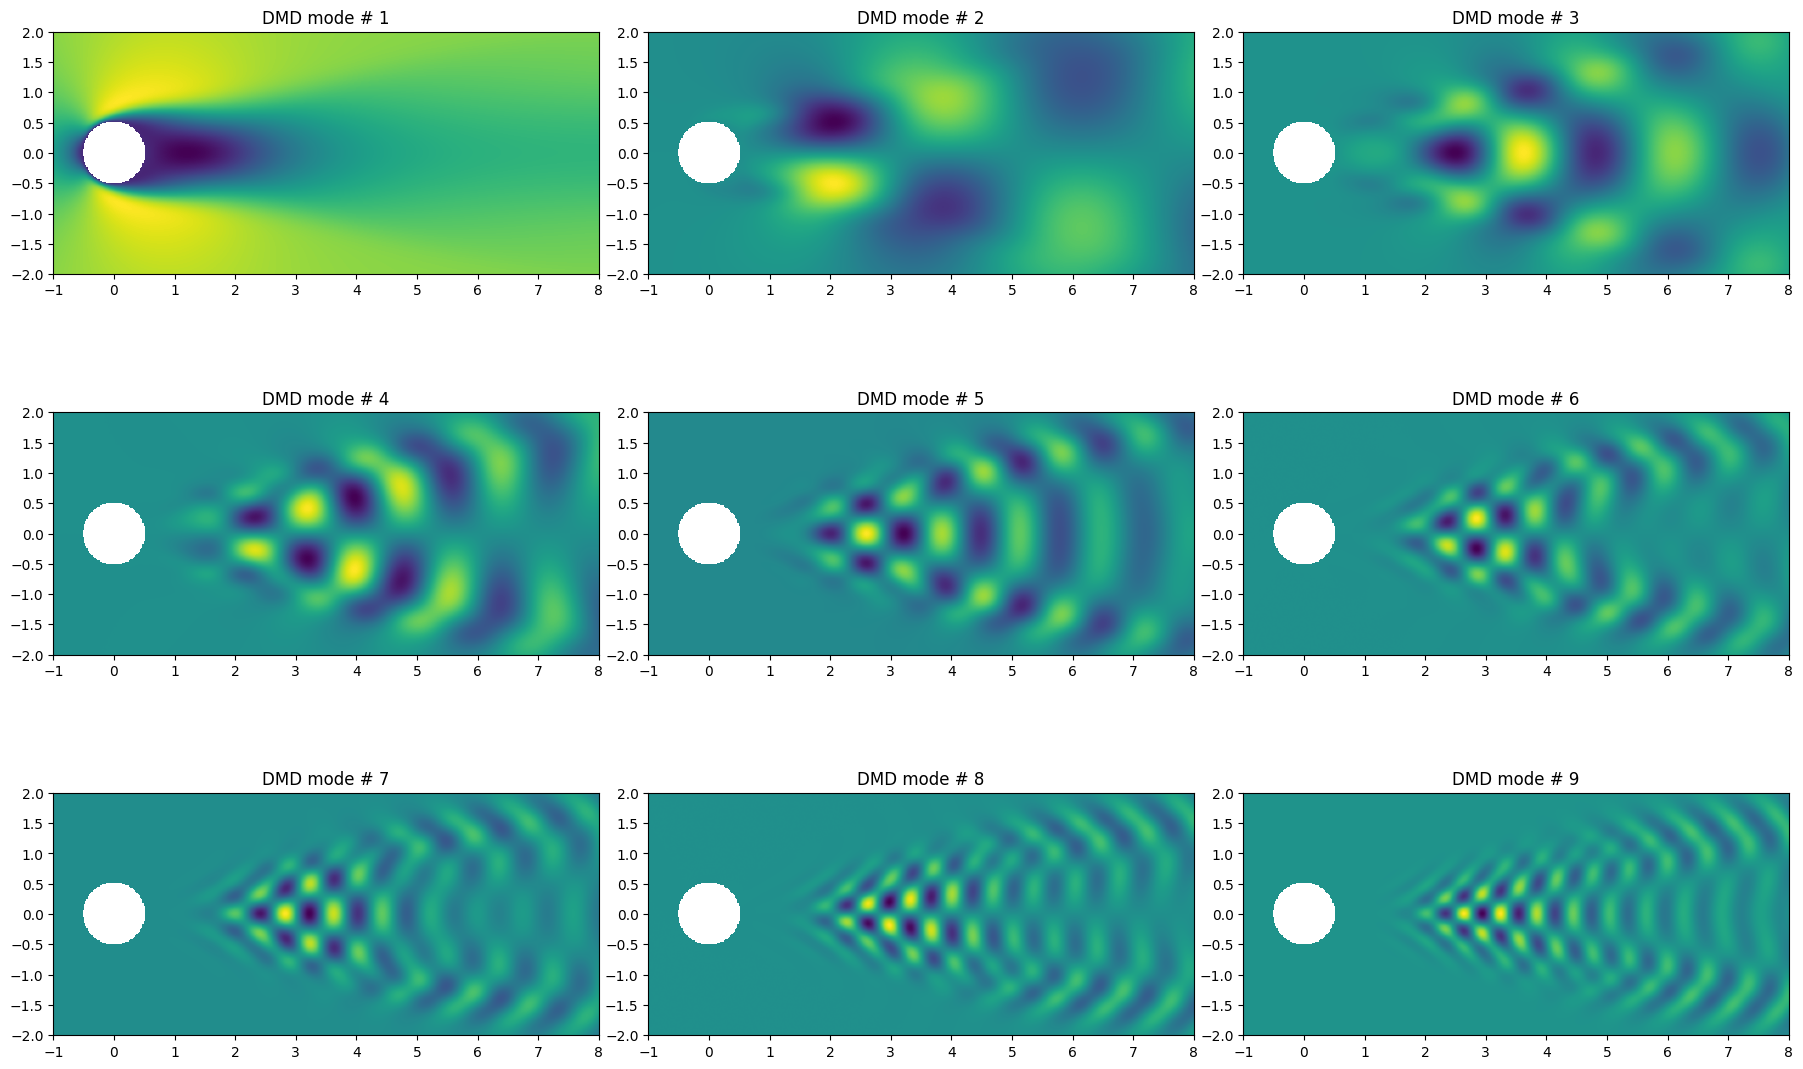

In [8]:
n_mode = np.arange(0, 18, 2)

fig, ax = plt.subplots(3, 3, figsize=(18, 12))

for i in range(3):
    for j in range(3):
        to_plot = np.real(reshaping(dmd.modes[:, n_mode[((i) * 3) + j]].copy()))
        to_plot[cylinder_idx] = np.nan
        im = ax[i, j].imshow(to_plot, extent=[-1, 8, -2, 2])
        ax[i, j].set_title(
            "DMD mode # {:d}".format(int((n_mode[((i) * 3) + j] + 2) / 2))
        )


fig.tight_layout();

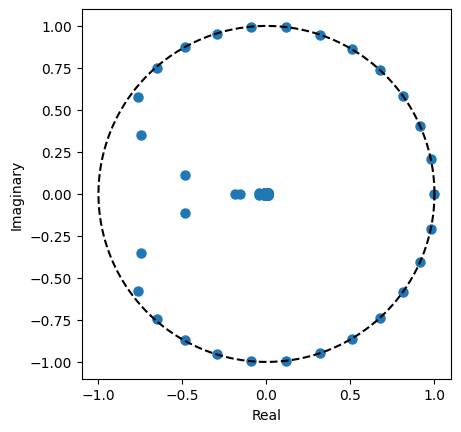

In [9]:
plt.plot(np.real(dmd.eigs), np.imag(dmd.eigs), ".", markersize=13)

theta = np.linspace(0, 2 * np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--")

plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.axis("square");